In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

In [13]:
TOL=np.radians(36.9)

plt.rcParams.update({
    'font.size': 14,
    'legend.fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large'})

In [14]:
@njit
def plus(x,y):
    return (x + y) % (2 * np.pi)

@njit
def diff(x,y):
    a, b = plus(x,-y), plus(-x,y)
    return np.where(a < b, a, b)

@njit
def within_tol(x, y, lon, lat, tol=TOL):
    x2, y2 = plus(x, np.pi), y
    d1 = np.sqrt(diff(lon,x)**2 + diff(lat,y)**2)
    d2 = np.sqrt(diff(lon,x2)**2 + diff(lat,y2)**2)
    return (np.abs(d1)<tol) | (np.abs(d2)<tol)

@njit
def find_plane(lon,lat, tol=TOL):
    b,v = -np.inf, None
    for i in np.linspace(0,2*np.pi,50):
        for j in np.linspace(0,2*np.pi,50):
            n = np.sum(within_tol(i,j,lon,lat,tol))
            if n>b:
                b = n
                v = i,j
    return b, v

# Simple median

subsumed 21.0


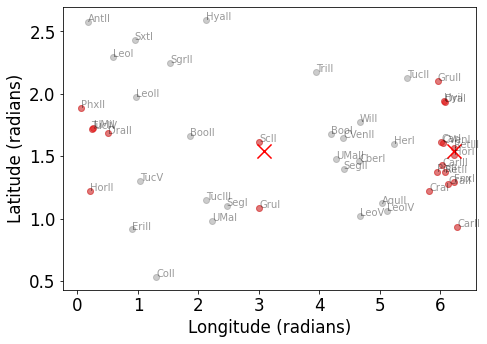

In [15]:
D = pd.read_csv("cartesian.csv")
l = D.name_abbr.values
p = D[["x_mid","y_mid","z_mid"]].values
p_r = np.sqrt(p[:,0]**2 + p[:,1]**2 + p[:,2]**2)
v = D[["vx_mid","vy_mid","vz_mid"]].values
c = np.cross(p,v,axis=1)
x,y,z = c[:,0], c[:,1], c[:,2]
r = np.sqrt(x**2 + y**2 + z**2)
lon = plus(np.arctan2(y,x),0)
lat = plus(np.arccos(z/r),0)

n, (i,j) = find_plane(lon,lat)
i2,j2 = plus(i,np.pi), j

print("subsumed", n)
q = within_tol(i,j, lon, lat)

plt.figure(figsize=(7,5))
plt.scatter(lon,lat, c="gray", alpha=.4)
plt.scatter(lon[q], lat[q], c="red", alpha=.4)
plt.scatter([i],[j], marker="x", color="red", s=200)
plt.scatter([i2],[j2], marker="x", color="red", s=200)
for i, txt in enumerate(l):
    plt.annotate(txt, (lon[i], lat[i]), fontsize=10, alpha=.4)
plt.xlabel("Longitude (radians)")
plt.ylabel("Latitude (radians)")
plt.tight_layout()

# Stochastic simulation

In [16]:
from scipy.stats import norm
from scipy.optimize import minimize

def eps_q(p, theta, sigma, eps):
    return theta + sigma*np.where(
        p<(1+eps)/2,
        (1+eps)*norm.ppf(p/(1+eps)),
        (1-eps)*norm.ppf((p-eps)/(1-eps)))

def eps_fit(q_16, q_50, q_84):
    Q = np.array([.16,.5,.84])
    V = np.array([q_16, q_50, q_84])
    res = minimize(
        lambda a: np.sqrt(((eps_q(Q, *a) - V)**2).sum()),
        [q_50, np.abs(q_50-q_16), 0],
        bounds=(
            (q_16, q_84),
            (0, q_84-q_16),
            (-1, 1)),
        method="Nelder-Mead")
    assert res.success
    return res.x

def rv(x):
    def f(y):
        params = eps_fit(*y)
        return lambda p: eps_q(p, *params)
    return [f(x[i]) for i in range(len(x))]

In [17]:
D = pd.read_csv("cartesian.csv")

# Positions and errors.
p_lo = D[["x-",   "y-",    "z-"]].values
p_50 = D[["x_mid","y_mid", "z_mid"]].values
p_hi = D[["x+",   "y+",    "z+"]].values
p_16 = p_50 - p_lo
p_84 = p_50 + p_hi 
P = lambda i: np.vstack([p_16[:,i], p_50[:,i], p_84[:,i]]).T

# Velocities and errors.
v_lo = D[["vx-",    "vy-",    "vz-"]].values
v_50 = D[["vx_mid", "vy_mid", "vz_mid"]].values
v_hi = D[["vx+",    "vy+",    "vz+"]].values
v_16 = v_50 - v_lo
v_84 = v_50 + v_hi 
V = lambda i: np.vstack([v_16[:,i], v_50[:,i], v_84[:,i]]).T

def sample(fx,fy,fz):
    n = len(fx)
    x = [f(p) for f,p in zip(fx, np.random.uniform(0,1,n))]
    y = [f(p) for f,p in zip(fy, np.random.uniform(0,1,n))]
    z = [f(p) for f,p in zip(fz, np.random.uniform(0,1,n))]
    return np.vstack([x,y,z]).T

def capture(pos, vel):
    ang = np.cross(pos, vel, axis=1)
    x,y,z = ang[:,0], ang[:,1], ang[:,2]
    r = np.sqrt(x**2 + y**2 + z**2)
    lon = plus(np.arctan2(y,x),0)
    lat = plus(np.arccos(z/r),0)
    _, (i,j) = find_plane(lon,lat)
    return np.sum(within_tol(i,j, lon, lat))

def simulate(N=500):
    p1, p2, p3 = rv(P(0)), rv(P(1)), rv(P(2))
    v1, v2, v3 = rv(V(0)), rv(V(1)), rv(V(2))
    while N > 0:
        N-=1
        pos = sample(p1,p2,p3)
        vel = sample(v1,v2,v3)
        c1 = capture(pos, vel)
        np.random.shuffle(vel)
        c2 = capture(pos, vel)
        yield c1, c2

In [18]:
%%time
res = np.array(list(simulate(5000)))

CPU times: user 4min 17s, sys: 39.8 ms, total: 4min 17s
Wall time: 4min 17s


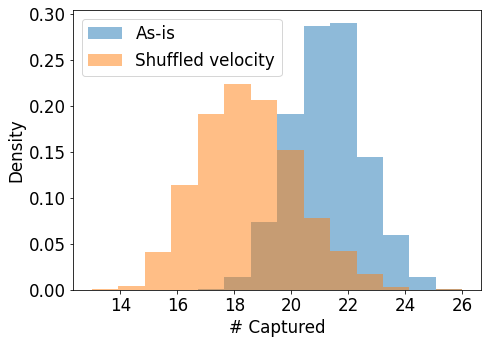

In [19]:
bins=np.histogram(res.flatten(), bins=14)[1]

plt.figure(figsize=(7,5))
plt.hist(res[:,0], bins, density=True, alpha=.5, label="As-is")
plt.hist(res[:,1], bins, density=True, alpha=.5, label="Shuffled velocity")
plt.xlabel("# Captured")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()

In [20]:
h0,_    = np.histogram(res[:,0], bins)
h1,_    = np.histogram(res[:,1], bins)
h       = np.vstack([h0,h1])
h       = np.min(h,axis=0)
h.sum() / np.sum(h0)

0.356